## 0. Setting up the Environment


In [1]:
## impoort labaries 
import os 
import cv2
import mat73
import time
import keras
import pandas as pd
import numpy as np 
import seaborn as sns
import skimage
import tensorflow as tf
import matplotlib.pyplot as plt
from PIL import Image, ImageOps 
from skimage.transform import resize
from keras.models import Sequential
from tensorflow.keras import optimizers
from tqdm.notebook import tqdm_notebook as tqdm
from sklearn.metrics import classification_report, confusion_matrix
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization,  Convolution2D

## 1. Data Importing 

In [2]:
SIZE_X = 128
SIZE_Y = 128

aug_train_DF = pd.read_pickle(r"../../../Datasets/Dataset_B/aug_train_DF_{}.pkl".format(SIZE_X))
aug_val_DF = pd.read_pickle(r"../../../Datasets/Dataset_B/aug_val_DF_{}.pkl".format(SIZE_X))
aug_test_DF = pd.read_pickle(r"../../../Datasets/Dataset_B/aug_test_DF_{}.pkl".format(SIZE_X))

In [3]:
## Combain the df with the Pitutary & Meningioma types with the dataframe of the Glioma grades (I, II,, IV).

pd.concat([aug_train_DF, aug_val_DF, aug_test_DF], axis=0, ignore_index = True).sample(5)

,PID,Label,Image,File
13348,114359,Meningioma,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",399.mat
5008,98241,Meningioma,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",423.mat
2139,HF1139,Glioma VI,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",D:\Datasets\manifest-tXudPFfp43472957274060920...
665,HF1398,Glioma III,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",D:\Datasets\manifest-tXudPFfp43472957274060920...
3385,103478,Pituitary,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",1504.mat


C:\Users\Ma7moud\anaconda3\envs\T-UNet\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


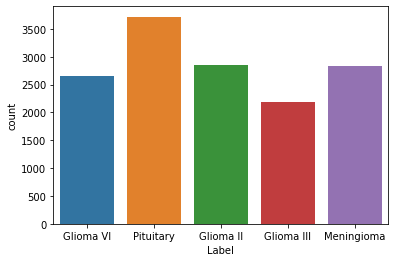

In [4]:
sns.countplot(pd.concat([aug_train_DF, aug_val_DF, aug_test_DF], axis=0, ignore_index = True).Label)
plt.show()

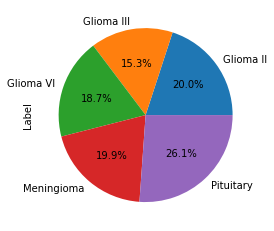

In [5]:
data = pd.concat([aug_train_DF, aug_val_DF, aug_test_DF], axis=0, ignore_index = True).groupby("Label")["Label"].count()
data.plot.pie(autopct="%.1f%%");

## 2. Data-Preprocessing 

### 2.1 Image Resizing 


### 2.2 Data Augmentation

### 2.3 Grayscale to RGB

In [6]:
def normalize(img):
    plt.imsave('DR.png', img, cmap='gray')
    return cv2.imread('DR.png')

In [7]:
aug_train_DF["Image"] = aug_train_DF["Image"].apply(normalize)
aug_val_DF["Image"] = aug_val_DF["Image"].apply(normalize)
aug_test_DF["Image"] = aug_test_DF["Image"].apply(normalize)

### 2.4 Splitting Data into Train, Test, and Validation Sets

In [8]:
y_train = aug_train_DF["Label"]
X_train = aug_train_DF['Image'].tolist()
X_train = np.array(X_train).reshape(-1, SIZE_X, SIZE_Y, 3)


y_val = aug_val_DF["Label"]
X_val = aug_val_DF['Image'].tolist()
X_val = np.array(X_val).reshape(-1, SIZE_X, SIZE_Y, 3)

y_test = aug_test_DF["Label"]
X_test = aug_test_DF['Image'].tolist()
X_test = np.array(X_test).reshape(-1, SIZE_X, SIZE_Y, 3)


In [9]:
print("X_train shape:", X_train.shape,"| y_train shape:", y_train.shape)
print("X_val shape  :",X_val.shape," | y_test shape : ", y_val.shape)
print("X_test shape :",X_test.shape," | y_test shape : ", y_test.shape)

X_train shape: (10676, 128, 128, 3) | y_train shape: (10676,)
X_val shape  : (1424, 128, 128, 3)  | y_test shape :  (1424,)
X_test shape : (2136, 128, 128, 3)  | y_test shape :  (2136,)


### 2.5 One-Hot Encode the labels 

In [10]:
# saving a copy of the testing labels before one hot encoding
y_test_eval = y_test
# one hot endcoding the labels 
y_train = pd.get_dummies(y_train)
y_test  = pd.get_dummies(y_test)
y_val   = pd.get_dummies(y_val)

In [11]:
print("X_train shape:", X_train.shape,"| y_train shape:", y_train.shape)
print("X_test shape :",X_test.shape," | y_test shape: ", y_test.shape)
print("X_val shape  :",X_val.shape," | y_val shape : ", y_val.shape)
print("\nTotal number: {}".format(len(aug_train_DF)+len(aug_val_DF)+len(aug_test_DF)))

X_train shape: (10676, 128, 128, 3) | y_train shape: (10676, 5)
X_test shape : (2136, 128, 128, 3)  | y_test shape:  (2136, 5)
X_val shape  : (1424, 128, 128, 3)  | y_val shape :  (1424, 5)

Total number: 14236


In [12]:
y_test

,Glioma II,Glioma III,Glioma VI,Meningioma,Pituitary
0,1,0,0,0,0
1,0,0,0,0,1
2,1,0,0,0,0
3,0,0,0,1,0
4,0,0,0,0,1
...,...,...,...,...,...
2131,0,0,0,0,1
2132,1,0,0,0,0
2133,0,0,0,0,1
2134,0,0,1,0,0


### 2.6 Image Normalizatoin

In [13]:
X_train = X_train / 255
X_val   = X_val / 255
X_test  = X_test / 255

In [14]:
## This Dictionary is used to decode the model's predicted values.  
decode_dict = {0 : "Glioma II", 1 : "Glioma III", 2 : "Glioma VI", 3: "Meningioma", 4: "Pituitary"}

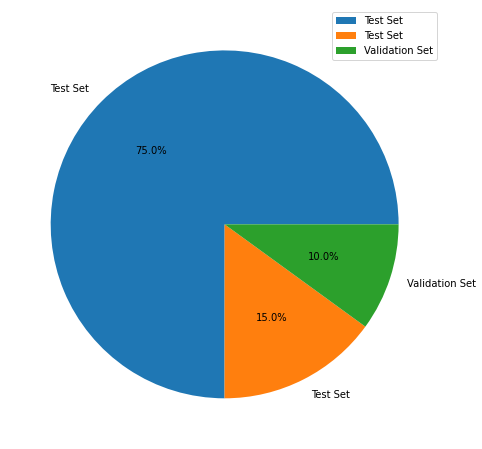

In [15]:
import matplotlib.pyplot as plt
import numpy as np
##  Creating a Pie chart illustrating the percentage of the train, validation, test sets.
Data = np.array([len(y_train), len(y_test), len(y_val)])
mylabels = ["Test Set", "Test Set", "Validation Set"]
plt.figure(figsize=(13, 8))
plt.pie(Data, labels = mylabels, autopct="%.1f%%", )
plt.legend()
plt.show() 

## 3. Models Creation


In [16]:


m1 = keras.models.Sequential([
    keras.layers.Conv2D(filters=96, kernel_size=(11,11), strides=(4,4), activation='relu', input_shape=(SIZE_X, SIZE_Y, 3)),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
    keras.layers.Conv2D(filters=256, kernel_size=(5,5), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
    keras.layers.Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
    keras.layers.Flatten(),
    keras.layers.Dense(4096, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(4096, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(5, activation='softmax')
])


m1.summary()
m1.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 30, 30, 96)        34944     
_________________________________________________________________
batch_normalization (BatchNo (None, 30, 30, 96)        384       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 96)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 256)       614656    
_________________________________________________________________
batch_normalization_1 (Batch (None, 14, 14, 256)       1024      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 6, 6, 256)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 6, 6, 384)         8

### 4. Model Training


In [17]:
from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor = 'loss', patience = 23 )

m1.fit(X_train,y_train,epochs=150,batch_size=32, validation_data=(X_val,y_val), callbacks = [early_stop], verbose=1)

Epoch 1/150
334/334 [==============================] - 8s 15ms/step - loss: 1.5107 - accuracy: 0.5457 - val_loss: 0.8774 - val_accuracy: 0.6215
Epoch 2/150
334/334 [==============================] - 4s 13ms/step - loss: 0.7389 - accuracy: 0.6827 - val_loss: 0.8117 - val_accuracy: 0.6622
Epoch 3/150
334/334 [==============================] - 4s 13ms/step - loss: 0.6218 - accuracy: 0.7398 - val_loss: 0.8755 - val_accuracy: 0.6798
Epoch 4/150
334/334 [==============================] - 4s 13ms/step - loss: 0.5257 - accuracy: 0.7853 - val_loss: 1.0498 - val_accuracy: 0.6594
Epoch 5/150
334/334 [==============================] - 4s 13ms/step - loss: 0.4439 - accuracy: 0.8206 - val_loss: 0.5941 - val_accuracy: 0.7809
Epoch 6/150
334/334 [==============================] - 4s 13ms/step - loss: 0.3976 - accuracy: 0.8388 - val_loss: 0.9064 - val_accuracy: 0.6847
Epoch 7/150
334/334 [==============================] - 4s 13ms/step - loss: 0.3380 - accuracy: 0.8648 - val_loss: 0.3432 - val_accuracy:

334/334 [==============================] - 4s 13ms/step - loss: 0.0118 - accuracy: 0.9972 - val_loss: 0.6021 - val_accuracy: 0.9382
Epoch 58/150
334/334 [==============================] - 4s 13ms/step - loss: 0.0332 - accuracy: 0.9911 - val_loss: 0.4613 - val_accuracy: 0.9305
Epoch 59/150
334/334 [==============================] - 4s 13ms/step - loss: 0.0501 - accuracy: 0.9888 - val_loss: 0.4610 - val_accuracy: 0.9368
Epoch 60/150
334/334 [==============================] - 4s 13ms/step - loss: 0.0406 - accuracy: 0.9914 - val_loss: 0.5052 - val_accuracy: 0.9305
Epoch 61/150
334/334 [==============================] - 4s 13ms/step - loss: 0.0214 - accuracy: 0.9950 - val_loss: 0.5401 - val_accuracy: 0.9347
Epoch 62/150
334/334 [==============================] - 4s 13ms/step - loss: 0.0366 - accuracy: 0.9925 - val_loss: 0.7041 - val_accuracy: 0.9164
Epoch 63/150
334/334 [==============================] - 4s 13ms/step - loss: 0.0188 - accuracy: 0.9957 - val_loss: 0.4317 - val_accuracy: 0.941

In [18]:
# Get training history
metrics = pd.DataFrame(m1.history.history)

In [19]:
import os
exp_num = []
if not os.path.exists("./experiments"):
    os.mkdir("./experiments")
folders = os.listdir("./experiments")
for folder in folders:
    exp_num.append(int(folder.split("#")[1]))


if len(exp_num) == 0:
    exp_path = r"./experiments/exp#1"
else:
    exp_path = r"./experiments/exp#"+str(max(exp_num)+1)




os.mkdir(exp_path)
os.mkdir(os.path.join(exp_path, "results"))
os.mkdir(os.path.join(exp_path, "weights"))

results = os.path.join(exp_path, "results")
weights = os.path.join(exp_path, "weights")

In [20]:
print(results)

./experiments/exp#2\results


In [21]:
# Save The Trained model along with it training history   
Accuracy = m1.evaluate(X_test, y_test)[-1]
name = str(round(Accuracy, 4))

metrics.to_pickle(os.path.join(results, name+'.pkl'))
m1.save(os.path.join(weights, name + '.h5'))

67/67 [==============================] - 1s 7ms/step - loss: 0.7280 - accuracy: 0.9307


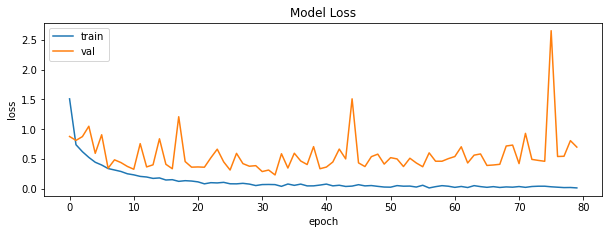

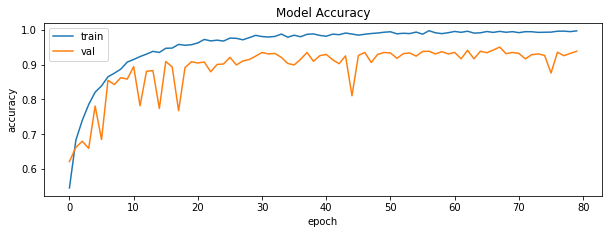

In [22]:
## Dispaly the plot of 
rows = 2
columns = 1
  
# Display Train loss vs Validation loss at each Epoch
fig = plt.figure(figsize=(10, 7))
fig.add_subplot(rows, columns, 1)
plt.plot(metrics['loss'])
plt.plot(metrics['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.savefig(os.path.join(results, 'loss_epoch.png'))
plt.show()

  
# Display Train loss vs Validation loss at each Epoch
fig = plt.figure(figsize=(10, 7))
fig.add_subplot(rows, columns, 2)
plt.plot(metrics['accuracy'])
plt.plot(metrics['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.savefig(os.path.join(results, 'acc_epoch.png'))
plt.show()



In [23]:
## Get the 
predict_x = m1.predict(X_test) 
predictions = np.argmax(predict_x,axis=1) 

In [24]:
# Decode the Model's predections  (from [0,1,0,2..] to ['Glioma','Meningioma'...]) of the Test set using the the dictionary 'decode_dict' 
predictions = np.vectorize(decode_dict.get)(predictions)

In [25]:
print(classification_report(y_test_eval, predictions))

              precision    recall  f1-score   support

   Glioma II       0.86      0.89      0.87       428
  Glioma III       0.92      0.90      0.91       356
   Glioma VI       0.89      0.87      0.88       420
  Meningioma       1.00      0.98      0.99       456
   Pituitary       0.98      1.00      0.99       476

    accuracy                           0.93      2136
   macro avg       0.93      0.93      0.93      2136
weighted avg       0.93      0.93      0.93      2136



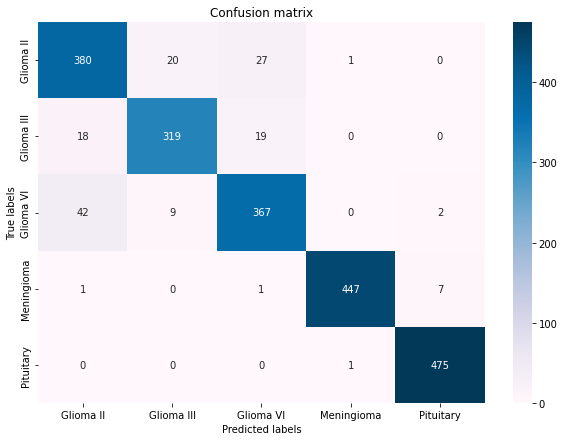

In [26]:
labels = sorted(["Glioma II", "Glioma III", "Glioma VI", "Meningioma", "Pituitary"])

cm = pd.DataFrame(confusion_matrix(y_test_eval, predictions), index=labels, columns=labels)
plt.figure(figsize = (10,7))
plt.title('Confusion matrix')
sns.heatmap(cm, annot=True, cmap="PuBu",fmt = 'd')
plt.ylabel('True labels')
plt.xlabel('Predicted labels')
plt.savefig(os.path.join(results, 'confusion_matrix.png'))
plt.show()